In [32]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import utils
import matplotlib
# import the CSV from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# this will return a pandas dataframe.

data = pd.read_csv('./data/kddcup_data_10_percent.csv',low_memory=False)

col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
data = pd.read_csv("./data/kddcup_data_10_percent.csv", header=None, names = col_names)


In [33]:
data.columns


Index([u'duration', u'protocol_type', u'service', u'flag', u'src_bytes',
       u'dst_bytes', u'land', u'wrong_fragment', u'urgent', u'hot',
       u'num_failed_logins', u'logged_in', u'num_compromised', u'root_shell',
       u'su_attempted', u'num_root', u'num_file_creations', u'num_shells',
       u'num_access_files', u'num_outbound_cmds', u'is_host_login',
       u'is_guest_login', u'count', u'srv_count', u'serror_rate',
       u'srv_serror_rate', u'rerror_rate', u'srv_rerror_rate',
       u'same_srv_rate', u'diff_srv_rate', u'srv_diff_host_rate',
       u'dst_host_count', u'dst_host_srv_count', u'dst_host_same_srv_rate',
       u'dst_host_diff_srv_rate', u'dst_host_same_src_port_rate',
       u'dst_host_srv_diff_host_rate', u'dst_host_serror_rate',
       u'dst_host_srv_serror_rate', u'dst_host_rerror_rate',
       u'dst_host_srv_rerror_rate', u'label'],
      dtype='object')

In [22]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [34]:
# extract just the logged-in HTTP accesses from the data
data = data[data['service'] == "http"]  
data = data[data["logged_in"] == 1]

In [26]:
data.head()
data.count()

duration                       58725
protocol_type                  58725
service                        58725
flag                           58725
src_bytes                      58725
dst_bytes                      58725
land                           58725
wrong_fragment                 58725
urgent                         58725
hot                            58725
num_failed_logins              58725
logged_in                      58725
num_compromised                58725
root_shell                     58725
su_attempted                   58725
num_root                       58725
num_file_creations             58725
num_shells                     58725
num_access_files               58725
num_outbound_cmds              58725
is_host_login                  58725
is_guest_login                 58725
count                          58725
srv_count                      58725
serror_rate                    58725
srv_serror_rate                58725
rerror_rate                    58725
s

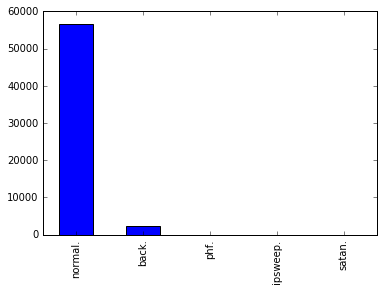

In [35]:
# let's take a look at the types of attack labels are present in the data.
data.label.value_counts().plot(kind='bar')  

In [36]:
# the full dataset contains features for SMTP, NDP, ICMP, etc.
# here we'll grab just the relevant features for HTTP. only three are relevant
relevant_features = [  
    "duration",
    "src_bytes",
    "dst_bytes",
    "label"
]
# replace the data with a subset containing only the relevant features
data = data[relevant_features]
# normalise the data - this leads to better accuracy and reduces numerical instability in
# the SVM implementation
data["duration"] = np.log((data["duration"] + 0.1).astype(float))  
data["src_bytes"] = np.log((data["src_bytes"] + 0.1).astype(float))  
data["dst_bytes"] = np.log((data["dst_bytes"] + 0.1).astype(float)) 

##### MAKING OUR DATA ONE-CLASS

Later we're going to use scikit-learn's OneClassSVM predict function to generate output. This returns +1 or -1 to indicate whether the data is an "inlier" or "outlier" respectively. To make comparison easier later we'll replace our data's label with a matching +1 or -1 value. This also transforms our data from multi-class (multiple different labels) to one-class (boolean label), which is a prerequisite for using a one-class SVM




In [37]:
# we're using a one-class SVM, so we need.. a single class. the dataset 'label'
# column contains multiple different categories of attacks, so to make use of 
# this data in a one-class system we need to convert the attacks into
# class 1 (normal) and class -1 (attack)
data.loc[data['label'] == "normal.", "attack"] = 1  
data.loc[data['label'] != "normal.", "attack"] = -1
# grab out the attack value as the target for training and testing. since we're
# only selecting a single column from the `data` dataframe, we'll just get a
# series, not a new dataframe
target = data['attack']
# find the proportion of outliers we expect (aka where `attack == -1`). because 
# target is a series, we just compare against itself rather than a column.
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", float(outliers.shape[0])/target.shape[0])
# drop label columns from the dataframe. we're doing this so we can do 
# unsupervised training with unlabelled data. we've already copied the label
# out into the target series so we can compare against it later.
data.drop(["label", "attack"], axis=1, inplace=True)

# check the shape for sanity checking.
data.shape  

('outliers.shape', (2209,))
('outlier fraction', 0.03761600681140911)


(58725, 3)

#### SPLITTING DATA INTO TRAINING AND TEST SETS



In [40]:
from sklearn.cross_validation import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
train_data.shape  

(46980, 3)

#### TRAINING THE MODEL

Now we're ready to train our model. We do this by calling the fit function from scikit-learn's svm.OneClassSVM. It accepts a few parameters but the most important are nu, kernel, and for the RBF kernel we'll be using, gamma.

nu is "An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors" and must be between 0 and 1. Basically this means the proportion of outliers we expect in our data. This is an important factor to consider when assessing algorithms. Many unsupervised ML algorithms require you to know (or hint at) the number of outliers or class members you expect.
kernel is the kernel type to be used. Earlier we discussed SVM's ability to use a non-linear function to project the hyperspace to higher dimension. Setting kernel to something other than linear here will achieve that. The default is rbf (RBF - radial basis function).
gamma is a parameter of the RBF kernel type and controls the influence of individual training samples - this effects the "smoothness" of the model. A low value improves the smoothness and "generalizability" of the model, while a high value reduces it but makes the model "tighter-fitted" to the training data. Some experimentation is often required to find the best value.
We already know that the proportion of attacks in our data is about 4%. We'll get the precise fraction and use that for nu below. Through experimentation I found an effective gamma to be 0.00005.

In our next cell we'll instantiate a model and fit (train) it with our training data.



In [42]:
from sklearn import svm

# set nu (which should be the proportion of outliers in our dataset)
nu = float(outliers.shape[0]) / target.shape[0]  
print("nu", nu)

model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)  
model.fit(train_data)

('nu', 0.03761600681140911)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.0376160068114, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

#### CHECKING ACCURACY OF THE MODEL

In [43]:
from sklearn import metrics  
preds = model.predict(train_data)  
targs = train_target
print ("====== Training Dataset Accuracy=======================")
print("Training Dataset accuracy: ", metrics.accuracy_score(targs, preds))  
print("Training Dataset precision: ", metrics.precision_score(targs, preds))  
print("Training Dataset recall: ", metrics.recall_score(targs, preds))  
print("Training Dataset f1: ", metrics.f1_score(targs, preds))  
print("Training Dataset area under curve (auc): ", metrics.roc_auc_score(targs, preds))  
print ("====== Test Dataset Accuracy=======================")

preds = model.predict(test_data)  
targs = test_target

print("Test Dataset accuracy: ", metrics.accuracy_score(targs, preds))  
print("Test Dataset precision: ", metrics.precision_score(targs, preds))  
print("Test Dataset recall: ", metrics.recall_score(targs, preds))  
print("Test Dataset f1: ", metrics.f1_score(targs, preds))  
print("Test Dataset area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

====== Training Dataset Accuracy=======================
('Training Dataset accuracy: ', 0.9772243507875692)
('Training Dataset precision: ', 0.99868899889243012)
('Training Dataset recall: ', 0.9776081424936387)
('Training Dataset f1: ', 0.98803613757323683)
('Training Dataset area under curve (auc): ', 0.97255757264737963)
====== Test Dataset Accuracy=======================
('Test Dataset accuracy: ', 0.97794806300553427)
('Test Dataset precision: ', 0.99918772563176894)
('Test Dataset recall: ', 0.97791714512852224)
('Test Dataset f1: ', 0.98843801615999294)
('Test Dataset area under curve (auc): ', 0.97834536501709124)
